# Telco Churn

In [69]:
# .py file imports 

from env import password, host, user, url
from env import sql_database
import acquire
import prepare

# Data science libraries
import pandas as pd
import numpy as np



# For exploration
from math import sqrt
from scipy import stats

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# For modeling
import model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



# Acquire

In [2]:
# This function checks to see if the csv file already exists. If it doesn't, it will create a new csv file.

# # acquire.check_for_csv_file("telco_churn_data.csv")

In [3]:
# df = acquire.sql_database()
# This function is used to pull the data from the SQL database

In [4]:
# acquire.pull_csv_file()
# This function converts the data to a csv so it is easier to access

In [5]:
# This function reads the csv data
telco = acquire.read_telco_data()

Why are customers churning?

My main hypothesis at the moment is that customers are churning because they don't see the value in our services, and as such, they are becoming very price driven. People in different contract, that don't churn after 1 month, usually have our premium packages. This is evident because only about 25% of our customers have the premium offerings

# Prepare

In [6]:
df = prepare.prep_data(telco)

# Split

In [7]:
train, validate, test = prepare.split_data(df)

In [8]:
train = prepare.encode_new_columns(train)
validate = prepare.encode_new_columns(validate)
test = prepare.encode_new_columns(test)

/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["partner_dependents"] = df.apply(lambda row: partner_dependents(row), axis = 1)
/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["streaming_features"] = df.apply(lambda row: streaming_features(row), axis = 1)
/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:111: Setting

# Explore

In [9]:
explore_int = train.select_dtypes(exclude="object")

Text(0.5, 1.0, 'Churn')

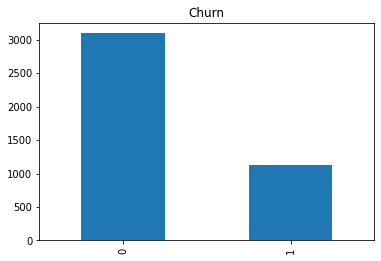

In [10]:
train.churn.value_counts().plot.bar().set_title("Churn")

About 26% of customers are currently churning

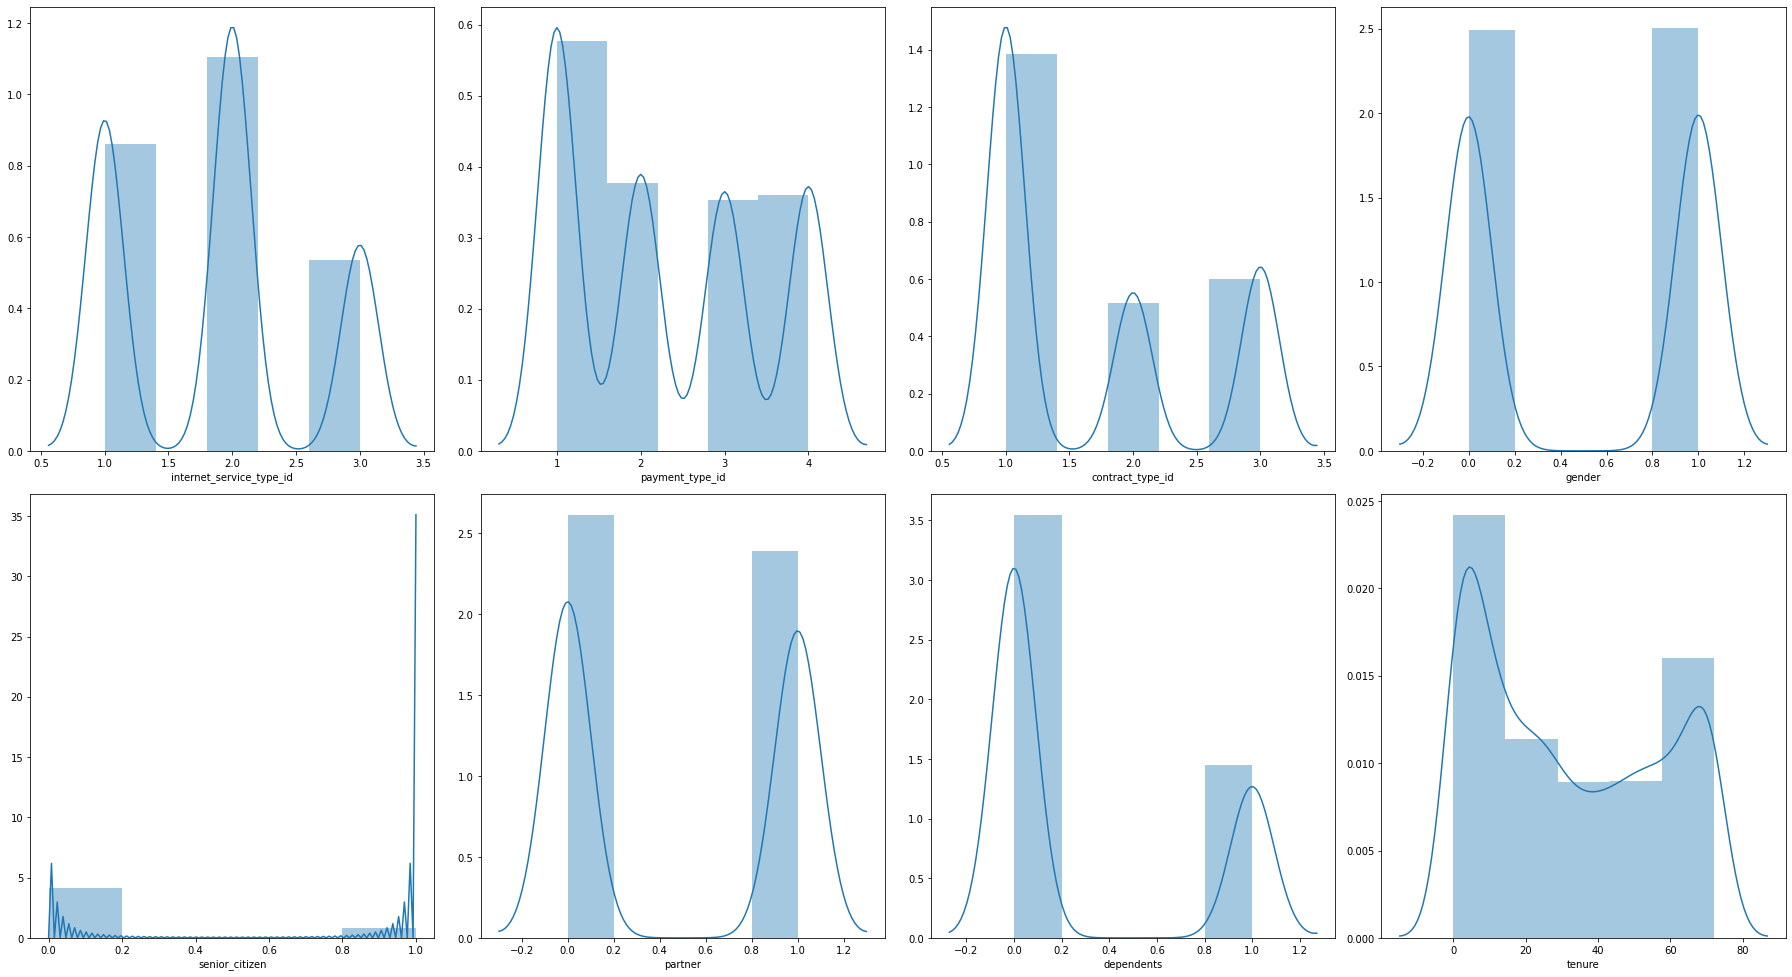

In [11]:
f = plt.figure(figsize=(25,20))
continuous_data = train.select_dtypes(include=["int", "float"])

for i in range(0,8):
    f.add_subplot(3,4, i+1)
    sns.distplot(continuous_data.iloc[:,i], bins=5)
plt.tight_layout()
plt.show()

Looking at the distribution of the data, we can see that most of the data is not normally distrubuted. We will do some exploration, and decide what columns to drop, before scaling using a linear scaler to evenly distribute the data.

## Is there a corelation between the variables?

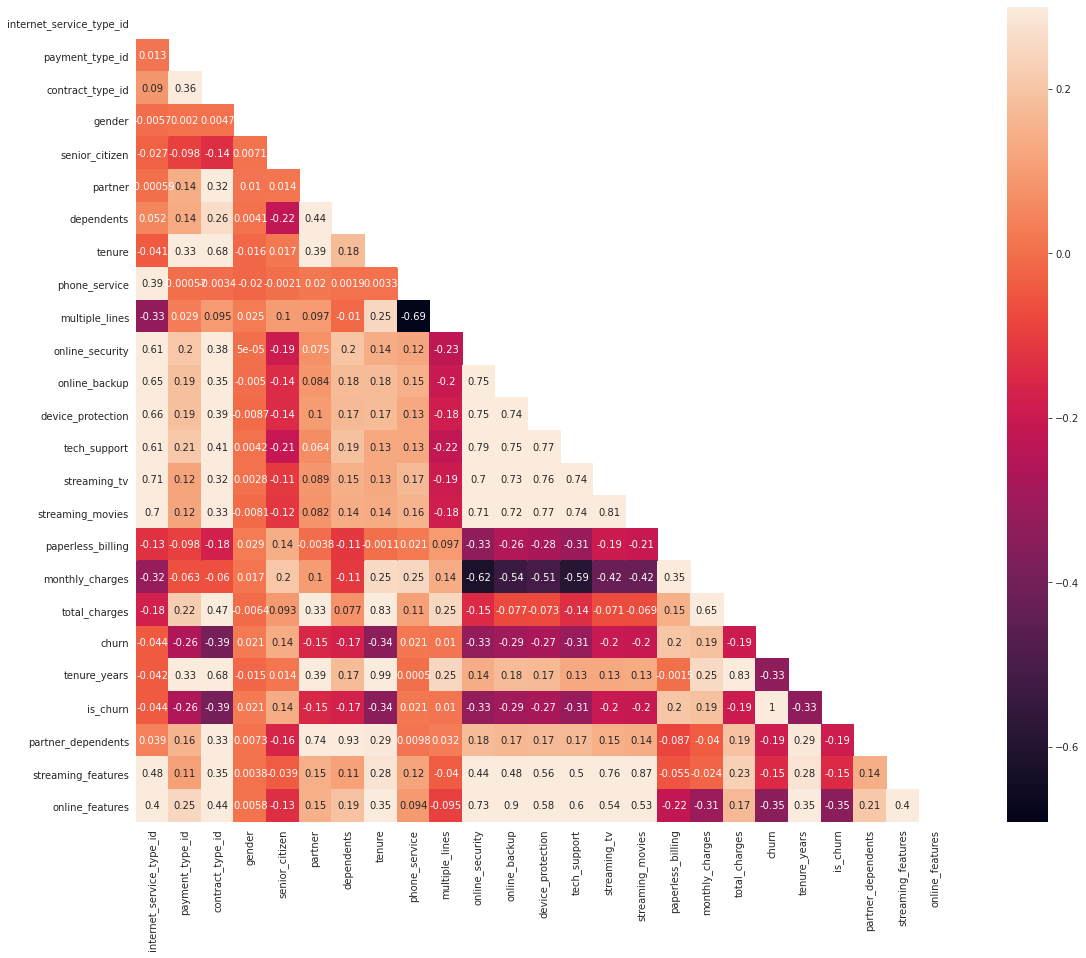

In [12]:
mask = np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
     f, ax = plt.subplots(figsize=(20, 15))
     ax = sns.heatmap(train.corr(), mask=mask, vmax=.3, square=True, annot=True)

## Are there clear groupings where a customer is more likely to churn?

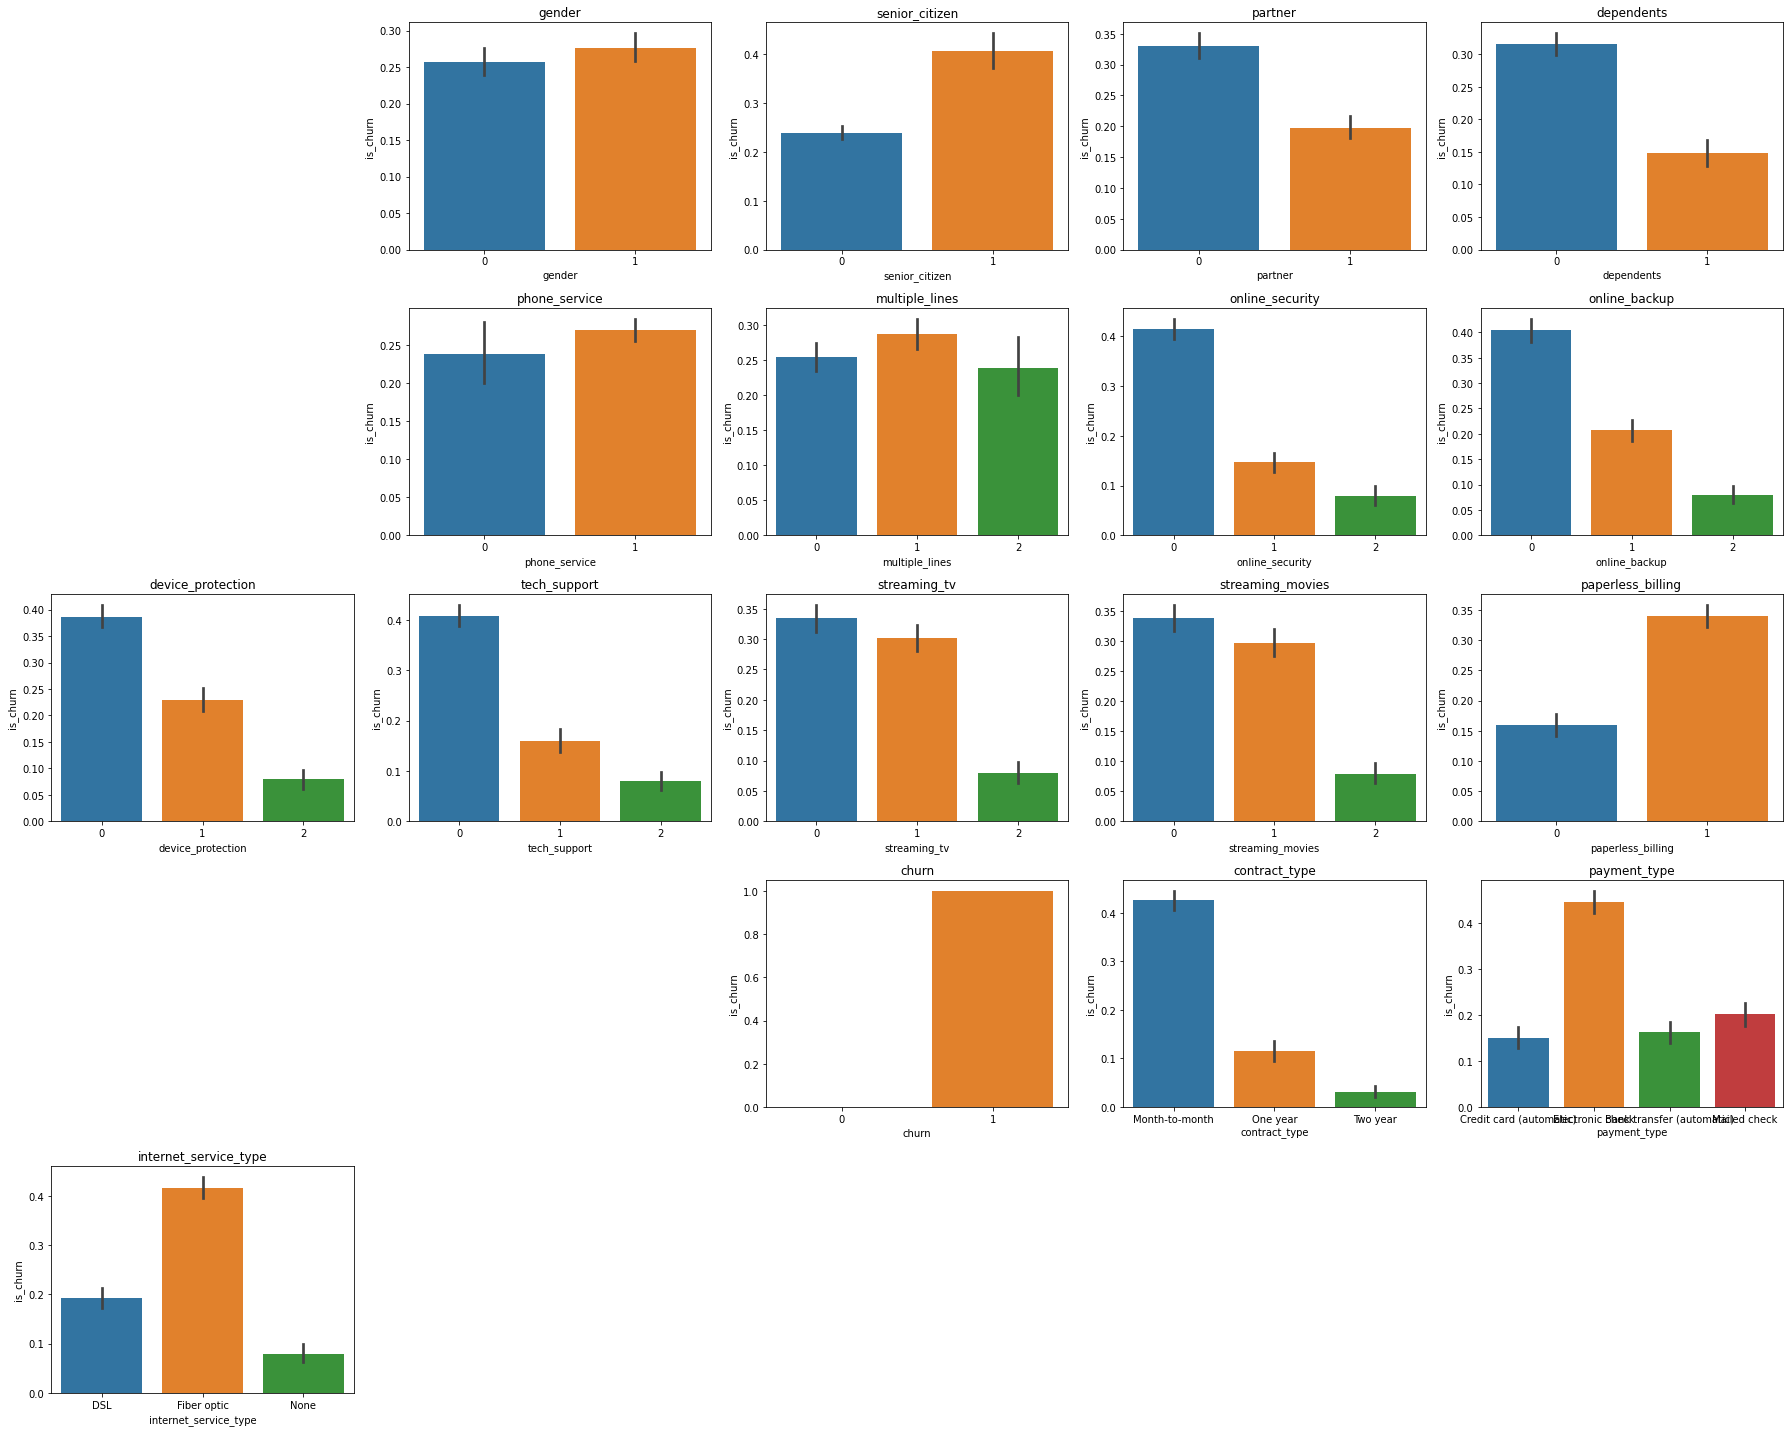

In [13]:
f = plt.figure(figsize=(25,20))

for i in range(0,21):
    if len(train.groupby(train.iloc[:,i+3])) < 5:
        f.add_subplot(5,5, i+1)
        sns.barplot(data=train, y="is_churn", x=train.iloc[:,i+3])
        plt.title(train.columns[i+3])
plt.tight_layout()
plt.show()

Are there clear groupings where a customer is more likely to churn?

There are actually quite a lot of groupings that can serve as an indicator of churn. It might be too many, however, and some new features might need to be engineered. 

From what we can see - the features that at this point don't seem to have any major differences are:

* `gender`
* `phone_service`
* `multiple_lines`
* `streaming_service`

The features that seems to be some of the best indicators are:

* `payment_type`
* `contract_type`
* `internet_service_type`
* `dependents`
* `partner`

Other features that are worth investigating are:

* `online_security`
* `tech_support`
* `senior_citizen` 
* `device_protection`

These features (with the exclusion of `senior_citizen`) seem to be additional commodities that are offered, and clients that usually take up on these features seem to be less likely to churn. While this might not be as useful for modeling, this can is something that can be used as a potential metric to improve customer rentention. 

It is important first to understand what percentage of the customer population actually has these features.

In [14]:
train[train["online_security"]== 1].customer_id.value_counts().sum() / train.shape[0]

0.2835502958579882

So about 28% of the customer population has opted in for online_security, which is actually higher than I initially suspected, and means it could be a good metric for modeling afterall.

In [15]:
train[train["tech_support"]== 1].customer_id.value_counts().sum() / train.shape[0]

0.2849704142011834

In [16]:
# Does this population overlap a lot? 

tech_support = train["tech_support"]== 1
security = train["online_security"]== 1

train[tech_support & security].customer_id.value_counts().sum() / train.shape[0]

0.15171597633136094

It doesn't seem that individuals have multiple "premium" features, as only 15% of the customer population has both options.

In [17]:
## At this point, we speculate that payment_type and contract_type have some of the bigger impact in customer churning. I will do a t-test to compare if there is a significant different.

# Below is a one-tail t test for all contract types:
for i in range(0,3):
    x = train[train.contract_type == train.contract_type.unique()[0 + i]].is_churn
    mu = train.is_churn.mean()

    t_stat, p = stats.ttest_1samp(x, mu)
    
    print(f"Contract Type = {train.contract_type.unique()[0 + i]}")
    print(f't = {t_stat:.3}')
    print(f'p = {p:.10f}')
    print()

Contract Type = Month-to-month
t = 15.5
p = 0.0000000000

Contract Type = One year
t = -14.1
p = 0.0000000000

Contract Type = Two year
t = -42.9
p = 0.0000000000



In [18]:
df[df.device_protection == 2].device_protection

5517    2
5518    2
5519    2
5520    2
5521    2
       ..
7038    2
7039    2
7040    2
7041    2
7042    2
Name: device_protection, Length: 1526, dtype: int64

In [19]:
telco.tech_support

0                        No
1                       Yes
2                        No
3                        No
4                        No
               ...         
7038    No internet service
7039    No internet service
7040    No internet service
7041    No internet service
7042    No internet service
Name: tech_support, Length: 7043, dtype: object

In [20]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?

group = ["online_security", "online_backup", "tech_support", "device_protection"]


pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="mean")

churn                                                                 0  \
online_security online_backup tech_support device_protection              
0               0             0            0                  64.264348   
                                           1                  77.810473   
                              1            0                  70.027670   
                                           1                  74.791748   
                1             0            0                  72.071067   
                                           1                  84.838028   
                              1            0                  77.339109   
                                           1                  89.859091   
1               0             0            0                  65.048485   
                                           1                  71.322436   
                              1            0                  64.100000   
                                           1                  80.074609   
                1             0            0                  72.972072   
                                           1                  84.613136   
                              1            0                  74.647170   
                                           1                  90.617096   
2               2             2            2                  21.199460   

churn                                                                 1  
online_security online_backup tech_support device_protection             
0               0             0            0                  70.307551  
                                           1                  82.483740  
                              1            0                  73.658511  
                                           1                  90.939744  
                1             0            0                  77.894175  
                                           1                  94.065663  
                              1            0                  79.621667  
                                           1                  92.889474  
1               0             0            0                  71.742857  
                                           1                  85.995238  
                              1            0                  78.632353  
                                           1                  84.503125  
                1             0            0                  78.700000  
                                           1                  90.797222  
                              1            0                  89.092857  
                                           1                  97.790909  
2               2             2            2                  20.320833

In [21]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?
group = ["online_security", "online_backup", "tech_support", "device_protection"]
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="count")

churn                                                           0    1
online_security online_backup tech_support device_protection          
0               0             0            0                  345  437
                                           1                  148  123
                              1            0                  103   47
                                           1                  103   39
                1             0            0                  178  103
                                           1                  142   83
                              1            0                  101   30
                                           1                  121   19
1               0             0            0                  132   56
                                           1                   78   21
                              1            0                   77   17
                                           1                  128   16
                1             0            0                  111   23
                                           1                  118   18
                              1            0                  106   14
                                           1                  272   11
2               2             2            2                  833   72

In [22]:
# Is there a difference in the number of ppl that have premium plans between the different contract types?

pd.pivot_table(train, index=group, columns="contract_type", values="monthly_charges")

contract_type                                                 Month-to-month  \
online_security online_backup tech_support device_protection                   
0               0             0            0                       67.571477   
                                           1                       80.008685   
                              1            0                       70.139189   
                                           1                       80.439706   
                1             0            0                       73.596121   
                                           1                       89.883462   
                              1            0                       73.073387   
                                           1                       89.029688   
1               0             0            0                       66.386667   
                                           1                       75.703846   
                              1            0                       70.472917   
                                           1                       82.881250   
                1             0            0                       71.622436   
                                           1                       82.640278   
                              1            0                       76.335938   
                                           1                       89.071429   
2               2             2            2                       20.431447   

contract_type                                                  One year  \
online_security online_backup tech_support device_protection              
0               0             0            0                  67.227273   
                                           1                  79.135556   
                              1            0                  75.300000   
                                           1                  74.302439   
                1             0            0                  76.683333   
                                           1                  88.215217   
                              1            0                  80.698684   
                                           1                  90.327778   
1               0             0            0                  71.979310   
                                           1                  71.578750   
                              1            0                  65.232258   
                                           1                  81.610465   
                1             0            0                  78.867073   
                                           1                  89.112766   
                              1            0                  75.140244   
                                           1                  90.428409   
2               2             2            2                  20.866514   

contract_type                                                  Two year  
online_security online_backup tech_support device_protection             
0               0             0            0                  84.087500  
                                           1                  81.423077  
                              1            0                  70.995455  
                                           1                  82.845455  
                1             0            0                  78.680000  
                                           1                  80.105769  
                              1            0                  83.961290  
                                           1                  90.859524  
1               0             0            0                  62.066667  
                                           1                  77.672500  
                              1            0                  57.836667  
                                           1                  79.262338  
                1

In [23]:
pd.pivot_table(train, index=group, columns="contract_type", values="monthly_charges", aggfunc="count")

contract_type                                                 Month-to-month  \
online_security online_backup tech_support device_protection                   
0               0             0            0                             745   
                                           1                             213   
                              1            0                             111   
                                           1                              68   
                1             0            0                             232   
                                           1                             130   
                              1            0                              62   
                                           1                              32   
1               0             0            0                             150   
                                           1                              39   
                              1            0                              48   
                                           1                              24   
                1             0            0                              78   
                                           1                              36   
                              1            0                              32   
                                           1                              21   
2               2             2            2                             318   

contract_type                                                 One year  \
online_security online_backup tech_support device_protection             
0               0             0            0                        33   
                                           1                        45   
                              1            0                        28   
                                           1                        41   
                1             0            0                        39   
                                           1                        69   
                              1            0                        38   
                                           1                        45   
1               0             0            0                        29   
                                           1                        40   
                              1            0                        31   
                                           1                        43   
                1             0            0                        41   
                                           1                        47   
                              1            0                        41   
                                           1                        44   
2               2             2            2                       218   

contract_type                                                 Two year  
online_security online_backup tech_support device_protection            
0               0             0            0                         4  
                                           1                        13  
                              1            0                        11  
                                           1                        33  
                1             0            0                        10  
                                           1                        26  
                              1            0                        31  
                                           1                        63  
1               0             0            0                         9  
                                           1                        20  
                              1            0                        15  
                                           1                        77  
                1             0            0      

Because the p-value for all is lower than our alpha ($\alpha = 0.05$), we know there is a significant difference in t-test between all of our contract types, and the mean. That being said, this is a very large data set, and a small p was expected. 

### Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

* $H_0$: There no difference in price for customers that have churn (when controlling for services) versus those that haven't churn.

* $H_a$: There is a difference in price for customers that have churn (when controlling for services) versus those that haven't churn.

$\alpha$ = 0.05

In [24]:
phone_id = train.phone_service == 1
internet = train.internet_service_type_id == 1
security = train.online_features == 0
support = train.tech_support == 0
device = train.device_protection == 0
contract = train.contract_type_id == 1
churn = train.is_churn == 1


x1 = train[phone_id & internet & security & support & device & contract & churn].monthly_charges
x2 = train[phone_id & internet & security & support & device & contract & ~churn].monthly_charges

t, p = stats.ttest_ind(x1,x2)

print(f"t = {t}")
print(f"p = {p:.6f}")

t = 0.1527237445184859
p = 0.878802


We see that in this case, we fail to reject the null hypothesis, as the mean monthly charges for customers that have churned versus customers that haven't churned are not significantly different. This means that customers aren't necesarly churning for price sensitive reasons. 

## Is there a significant difference in monthly charges between customers that use automatic banking?

* $H_0$: There no difference in churn rate for customers that use automatic payments.

* $H_a$: There is a difference in churn rate for customers that use automatic payments.

$\alpha$ = 0.05

In [25]:
train.payment_type

440       Credit card (automatic)
67               Electronic check
600       Credit card (automatic)
4883      Credit card (automatic)
1258    Bank transfer (automatic)
                  ...            
1794      Credit card (automatic)
817                  Mailed check
901              Electronic check
1987    Bank transfer (automatic)
6958    Bank transfer (automatic)
Name: payment_type, Length: 4225, dtype: object

In [26]:
card = train.payment_type == "Credit card (automatic)"
bank = train.payment_type == "Bank transfer (automatic)" 
automatic_banking = card | bank
churn = train.is_churn == 1

x1 = train[automatic_banking].is_churn
x2 = train[~automatic_banking].is_churn

t, p = stats.ttest_ind(x1,x2)

print(f"t = {t}")
print(f"p = {p:.6f}")

t = -14.400519026868128
p = 0.000000


In [27]:
x1 = train[automatic_banking].is_churn.mean()
x2 = train[~automatic_banking].is_churn.mean()

if x1 < x2:
    print("On average, there is a significant difference in churn rate between customers that use the automatic payment methods, versus those who didn't")
else: 
    print("There is no significant difference in churn rate")

On average, there is a significant difference in churn rate between customers that use the automatic payment methods, versus those who didn't


Because our p-value is smaller than our alpha - we can reject the null hypothesis.

## Is there a tenure that month-to-month customers are most likely to churn

In [28]:
train.groupby(["is_churn", "contract_type"]).tenure.mean()

is_churn  contract_type 
0         Month-to-month    20.236960
          One year          40.900259
          Two year          56.945010
1         Month-to-month    13.606820
          One year          47.200000
          Two year          60.406250
Name: tenure, dtype: float64

In [29]:
for i in range(0, 3):
    print(f'''
    The average number of months we retain a customer on a {train.contract_type.unique()[0 + i]} contract is: {train[train["contract_type"] == train.contract_type.unique()[0 + i]].tenure.mean():.2f}
    '''
    )


    The average number of months we retain a customer on a Month-to-month contract is: 17.41
    

    The average number of months we retain a customer on a One year contract is: 41.62
    

    The average number of months we retain a customer on a Two year contract is: 57.05
    


In [30]:
# How many ppl are in each contract type?

train.groupby("contract_type").contract_type.count()

contract_type
Month-to-month    2339
One year           872
Two year          1014
Name: contract_type, dtype: int64

The majority of customers are on a one-month contract. Which means that this is the "leacky bucket".

In [31]:
# What is the total revenue, by contract?

train.groupby("contract_type").total_charges.mean()

contract_type
Month-to-month    1313.218384
One year          3013.493463
Two year          3774.870858
Name: total_charges, dtype: float64

Not surprisingly, the majority of the revenue comes from customers in two-year contracts. THese are the high value targets. The revenue from monthly customers is also substancial, and this acrtually is likely to have the most room for improvement, given that the churn is so high.

In [32]:
train[train["contract_type"] == "Month-to-month"].groupby("tenure").is_churn.agg(["mean", "sum"]).nlargest(15, columns="sum")

,mean,sum
tenure,,
1,0.612299,229
2,0.496599,73
3,0.466667,56
4,0.481132,51
5,0.481481,39
7,0.476923,31
9,0.461538,30
10,0.491803,30
8,0.426230,26


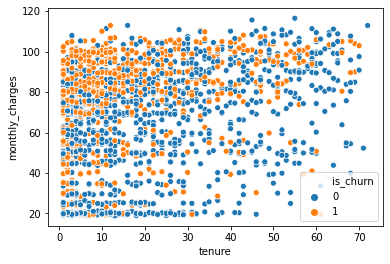

In [33]:
sns.scatterplot(data=train[train.contract_type == "Month-to-month"], x="tenure", y="monthly_charges", hue="is_churn")

Interesting finding - about 852 ppl are churning after the first 5 months for customers that have a monthly contract. It doesn't seem that price alone is the main driver, as there are plently of users that are paying in near the upper bound and aren't churning.

Do customers that churn after the first month have premium offerings?

In [34]:
tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    feature = train[group.columns[i]] == 1
    print(group.columns[i])
    print(f"{train[tenure & churn & feature & contract][group.columns[i]].sum()}, out of {train[tenure & churn & contract].shape[0]}")
    print()


Customers that churned on a Month-to-month contract during the first 5 months
online_security
35, out of 448

online_backup
52, out of 448

tech_support
43, out of 448

device_protection
61, out of 448



In [35]:
tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that didn't churn on a Month-to-month contract after 5 months")
for i in range(0,4):
    feature = train[group.columns[i]] == 1
    print(group.columns[i])
    print(f"{train[tenure & ~churn & feature & contract][group.columns[i]].sum()}, out of {train[tenure & churn & contract].shape[0]}")
    print()

Customers that didn't churn on a Month-to-month contract after 5 months
online_security
50, out of 448

online_backup
53, out of 448

tech_support
45, out of 448

device_protection
34, out of 448



In [36]:
train.payment_type

440       Credit card (automatic)
67               Electronic check
600       Credit card (automatic)
4883      Credit card (automatic)
1258    Bank transfer (automatic)
                  ...            
1794      Credit card (automatic)
817                  Mailed check
901              Electronic check
1987    Bank transfer (automatic)
6958    Bank transfer (automatic)
Name: payment_type, Length: 4225, dtype: object

In [37]:
# What about for payment methods?

tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    payment = train.payment_type == train.payment_type.unique()[0 + i]
    print(train.payment_type.unique()[0 + i])
    print(f"{train[tenure & churn & contract & payment].shape[0]}, out of {train[tenure & churn & contract].shape[0]}")
    print()


Customers that churned on a Month-to-month contract during the first 5 months
Credit card (automatic)
27, out of 448

Electronic check
264, out of 448

Bank transfer (automatic)
31, out of 448

Mailed check
126, out of 448



In [38]:
# What about for payment methods?

tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    payment = train.payment_type == train.payment_type.unique()[0 + i]
    print(train.payment_type.unique()[0 + i])
    print(f"{train[tenure & ~churn & contract & payment].shape[0]}, out of {train[tenure & ~churn & contract].shape[0]}")
    print()

Customers that churned on a Month-to-month contract during the first 5 months
Credit card (automatic)
38, out of 380

Electronic check
140, out of 380

Bank transfer (automatic)
27, out of 380

Mailed check
175, out of 380



In [39]:
# What is the payment method distribution?

train.payment_type.value_counts()

Electronic check             1462
Mailed check                  955
Credit card (automatic)       913
Bank transfer (automatic)     895
Name: payment_type, dtype: int64

In [40]:
pd.pivot_table(train, index=["senior_citizen", "dependents", "gender", "partner"], values="monthly_charges", columns="payment_type")

payment_type                              Bank transfer (automatic)  \
senior_citizen dependents gender partner                              
0              0          0      0                        63.639041   
                                 1                        71.759524   
                          1      0                        65.775000   
                                 1                        69.592268   
               1          0      0                        48.100000   
                                 1                        65.665487   
                          1      0                        57.042857   
                                 1                        64.776582   
1              0          0      0                        66.602000   
                                 1                        81.424468   
                          1      0                        82.308621   
                                 1                        85.755172   
               1          0      0                              NaN   
                                 1                        58.350000   
                          1      0                              NaN   
                                 1                        73.462500   

payment_type                              Credit card (automatic)  \
senior_citizen dependents gender partner                            
0              0          0      0                      60.071831   
                                 1                      70.337931   
                          1      0                      63.452961   
                                 1                      74.393548   
               1          0      0                      52.437931   
                                 1                      64.953516   
                          1      0                      59.205769   
                                 1                      63.785081   
1              0          0      0                      66.580769   
                                 1                      74.610294   
                          1      0                      83.263333   
                                 1                      87.456452   
               1          0      0                      94.800000   
                                 1                      84.775000   
                          1      0                            NaN   
                                 1                      91.487500   

payment_type                              Electronic check  Mailed check  
senior_citizen dependents gender partner                                  
0              0          0      0               71.618089     40.825781  
                                 1               83.131780     56.278302  
                          1      0               71.175493     43.561239  
                                 1               78.091453     51.956897  
               1          0      0               69.104839     37.512222  
                                 1               73.179048     40.806579  
                          1      0               70.277500     43.298438  
                                 1               71.386893     36.831933  
1              0          0      0               79.323295     64.835000  
                                 1               86.715132     60.271429  
                          1      0               76.620492     53.304545  
                                 1               84.633594     54.221429  
               1          0      0                     NaN     80.450000  
                                 1               87.400000     67.000000  
                          1      0              101.300000           NaN  
                                 1               82.850000     61.150000

My new theory is that payment method is likely to be the best reason why customers churn, along with other potential reasons. This means to indicate that customers not on automatic payments are more likely to churn. There is not one particular demographic that is more likely to use the electronic check, which leads me to believe this can be a good indicator of churn probability.

## Is there a tenure that one year customers are most likely to churn

In [41]:
train[train["contract_type"] == "One year"].groupby("tenure").is_churn.agg(["mean", "sum"]).nlargest(15, columns="sum")

,mean,sum
tenure,,
58,0.315789,6
67,0.285714,6
53,0.200000,5
48,0.285714,4
54,0.266667,4
66,0.181818,4
39,0.272727,3
45,0.250000,3
46,0.272727,3


In [42]:
tenure = train.tenure == 12
contract = train.contract_type == "One year"

train[tenure & contract].is_churn.sum()

2

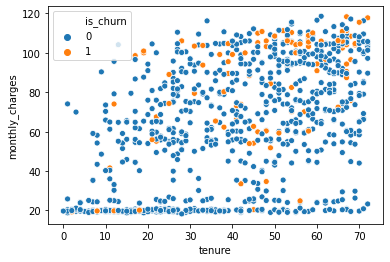

In [43]:
sns.scatterplot(data=train[train.contract_type == "One year"], x="tenure", y="monthly_charges", hue="is_churn")

Weirdly - is doesn't seem that there are a lot of customers that are churning after 12 months, which is what you would expect. 

Not as many people churning on one-year contracts (~230). They are the smallest group. There is no particular tenure month that seems to have the highest churn rate.

## ## Is there a tenure that two year customers are most likely to churn

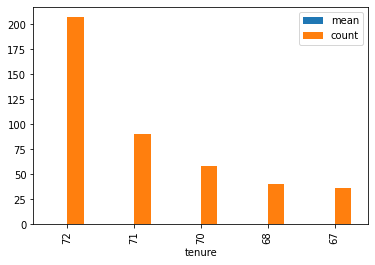

In [44]:
train[train["contract_type"] == "Two year"].groupby("tenure").is_churn.agg(["mean", "count"]).nlargest(5, columns="count").plot.bar()

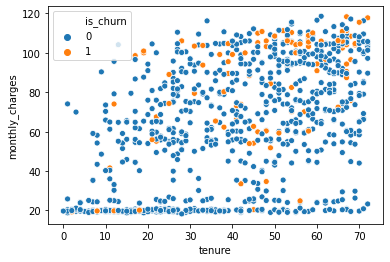

In [45]:
sns.scatterplot(data=train[train.contract_type == "One year"], x="tenure", y="monthly_charges", hue="is_churn")

It seems that most customers on two -year contracts begin to churn after 70 months or more. Other than that, it seems fairly low. 

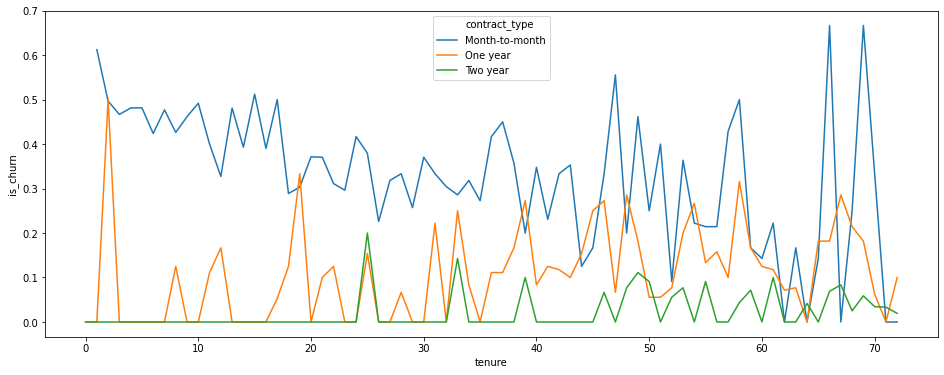

In [46]:
plt.figure(figsize=(16,6))
sns.lineplot('tenure', 'is_churn', hue='contract_type', data=train, ci=None)

## If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

$churn\_rate = \frac{(n\_users_0 - n\_users_n)}{n_users_0}$
$for \  _n \ months$

In [47]:
contract = train.contract_type == "Month-to-month"
no_churn = train.churn == "No"
tenure = train.tenure <= 12


churn_rate_m = (train[contract & tenure].shape[0] - train[contract & no_churn & tenure].shape[0]) / train[contract & tenure].shape[0]

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [48]:
contract = train.contract_type == "One year"
no_churn = train.churn == "No"
tenure = train.tenure <= 12

churn_rate_1 = (train[contract & tenure].shape[0] - train[contract & no_churn & tenure].shape[0]) / train[contract & tenure].shape[0]

In [49]:
print(f'''

After the 12th month, the churn rate for customers on a month-to-month plan is {churn_rate_m:.1%}, while for customers on a 1-year plan is {churn_rate_1:.1%}

The clearly tells us that the churn rate is not comparable between both services. The key-takeway here is that we need to convert more month-to-month customers into yearly customers, as they are less likely to churn
''')



After the 12th month, the churn rate for customers on a month-to-month plan is 100.0%, while for customers on a 1-year plan is 100.0%

The clearly tells us that the churn rate is not comparable between both services. The key-takeway here is that we need to convert more month-to-month customers into yearly customers, as they are less likely to churn



## Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).

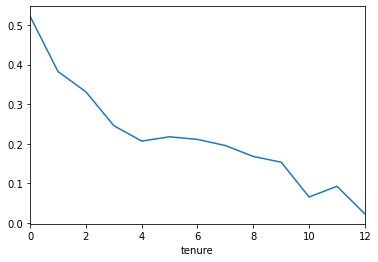

In [50]:
train.groupby(train.tenure // 6).is_churn.mean().plot()

## Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

# Scaling

Now that the exploration is done - we need to start scaling the data so that we can model it.

In [51]:
X_train, X_validate, X_test = prepare.prep_for_modeling(train, validate, test)

In [52]:
y_train = train.is_churn
y_validate = validate.is_churn
y_test = test.is_churn

In [53]:
# We make sure that the data is still what we think it is, by ensuring that 
# our data shape is still accurate

assert(X_train.shape[0] == train.shape[0])
assert(X_validate.shape[0] == validate.shape[0])
assert(X_test.shape[0] == test.shape[0])

assert(y_train.shape[0] == train.shape[0])
assert(y_validate.shape[0] == validate.shape[0])
assert(y_test.shape[0] == test.shape[0])

# Modeling

In [54]:
evaluation = pd.DataFrame({"actual": y_train})

### Decision Tree Classifier

In [55]:
def run_clf(X_train, y_train, max_depth):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=123)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    return clf,y_pred

In [56]:
for i in range(1,26):
    clf, y_pred = run_clf(X_train, y_train, i)
    print(f'max_depth = {i}, train_accuracy = {clf.score(X_train, y_train):.2%}, diff_accuracy = {(clf.score(X_train, y_train) - clf.score(X_validate, y_validate))/clf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 3, train_accuracy = 77.14%, diff_accuracy = -2%
max_depth = 4, train_accuracy = 78.84%, diff_accuracy = -2%
max_depth = 5, train_accuracy = 79.95%, diff_accuracy = 1%
max_depth = 6, train_accuracy = 80.47%, diff_accuracy = 3%
max_depth = 7, train_accuracy = 81.61%, diff_accuracy = 4%
max_depth = 8, train_accuracy = 82.89%, diff_accuracy = 7%
max_depth = 9, train_accuracy = 84.45%, diff_accuracy = 9%
max_depth = 10, train_accuracy = 85.63%, diff_accuracy = 11%
max_depth = 11, train_accuracy = 87.17%, diff_accuracy = 15%
max_depth = 12, train_accuracy = 89.11%, diff_accuracy = 17%
max_depth = 13, train_accuracy = 90.89%, diff_accuracy = 21%
max_depth = 14, train_accuracy = 92.92%, diff_accuracy = 26%
max_depth = 15, train_accuracy = 94.22%, diff_accuracy = 27%
max_depth = 16, train_accuracy = 95.69%, diff_accuracy = 31%
max_depth = 17, train_accuracy = 96.62

The danger with Decision tree is that it can very easily become over fit. With the loop above, we can see all the different accuracy scores for many different values for `max_depth`. Based on the information, we want to keep a train accuracy as high as possible, while still ensuring that the model is not overfit. If we choose a `max_depth` of 10, we can get an accuracy of 85%, and keep the difference between train and validate samples relatively small.

In [57]:
clf, y_pred = run_clf(X_train, y_train, 10)
evaluation["decision_tree_model"] = y_pred

In [58]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

labels = sorted(y_train.unique())
pd.DataFrame(confusion_matrix(evaluation.actual, evaluation.iloc[:,1]), index = labels, columns = labels)

Accuracy of Decision Tree classifier on training set: 0.86


,0,1
0,2825,271
1,336,793


In [59]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3096
           1       0.75      0.70      0.72      1129

    accuracy                           0.86      4225
   macro avg       0.82      0.81      0.81      4225
weighted avg       0.85      0.86      0.85      4225



Overall, we see that the model is doing fairly well at predicting values when the positive is `not_churning`. While this is good, this is not what we are looking for, as we want to predict the probability that a customer will churn. The precision and recall values are still good when we look at churning as the positive, but they need to be substancially imporved, as failing to accurately predict if a customer will churn can cost the company significant money.

### Random Forest

In [60]:
telco = acquire.read_telco_data()

In [61]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [87]:
for i in range(1,26):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(clf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = 15%
max_depth = 2, train_accuracy = 77.94%, diff_accuracy = 7%
max_depth = 3, train_accuracy = 79.22%, diff_accuracy = 6%
max_depth = 4, train_accuracy = 79.29%, diff_accuracy = 6%
max_depth = 5, train_accuracy = 79.88%, diff_accuracy = 6%
max_depth = 6, train_accuracy = 81.09%, diff_accuracy = 6%
max_depth = 7, train_accuracy = 82.44%, diff_accuracy = 6%
max_depth = 8, train_accuracy = 84.71%, diff_accuracy = 7%
max_depth = 9, train_accuracy = 86.98%, diff_accuracy = 6%
max_depth = 10, train_accuracy = 89.35%, diff_accuracy = 5%
max_depth = 11, train_accuracy = 91.72%, diff_accuracy = 8%
max_depth = 12, train_accuracy = 93.94%, diff_accuracy = 8%
max_depth = 13, train_accuracy = 95.36%, diff_accuracy = 8%
max_depth = 14, train_accuracy = 96.38%, diff_accuracy = 9%
max_depth = 15, train_accuracy = 97.21%, diff_accuracy = 8%
max_depth = 16, train_accuracy = 97.89%, diff_accuracy = 9%
max_depth = 17, train_accuracy = 98.11%, diff_ac

In [91]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 10)
evaluation["random_forest_model"] = y_pred

In [92]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(evaluation.actual, evaluation.iloc[:,2]), index = labels, columns = labels)

Accuracy of Decision Tree classifier on training set: 0.89


,0,1
0,2933,163
1,287,842


In [93]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3096
           1       0.84      0.75      0.79      1129

    accuracy                           0.89      4225
   macro avg       0.87      0.85      0.86      4225
weighted avg       0.89      0.89      0.89      4225

